### Q: Design and conduct an experiment to demonstrate the dificulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q\*(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the q\*(a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps.

In [4]:
import random
import matplotlib.pyplot as plt

**Criando classe base para Ambiente**

In [10]:
class Environment:
    def evaluate(self, action):
        self._before_evaluate()
        reward = self._evaluate(action)
        self._after_evaluate()
        return reward

    def _before_evaluate(self):
        pass

    def _after_evaluate(self):
        pass

    def _evaluate(self, action):
        raise NotImplementedError

**Criando a classe para o Ambiente proposto pela questão**

A cada passo a recompensa de cada ação é incrementado por um valor aleatório gerado por uma distribuição normal

In [11]:
class NormalRandomEnvironment(Environment):
    def __init__(self, actions=None, initial_value=5, q_stars=None, mean=0, standard_deviation=0.01):
        self._actions = actions
        self.mean = mean
        self.standard_deviation = standard_deviation
        self._q_stars = q_stars or {a: initial_value for a in actions}
        self._initial_q_stars = self._q_stars
    
    def reset(self):
        self._q_stars = self._initial_q_stars

    def _evaluate(self, action):
        return self._q_stars[action]

    def _after_evaluate(self):
        self._q_stars = {a: q + random.gauss(self.mean, self.standard_deviation) for a, q in self._q_stars.items()}

**Criando a classe base do algoritmo K-Armed Testbed**

In [12]:
class KArmedTestbed:
    def __init__(self, actions, epsilon, learning_rate, initial_value=0):
        self.initial_value = initial_value
        
        self._Q = None
        self._actions = actions
        self._training_steps = None

        self.epsilon = epsilon
        self.learning_rate = learning_rate

        self.reset()

    @property
    def total_steps(self):
        return len(self._training_step_actions)
    
    @property
    def training_steps(self):
        return list(self._training_steps)
    
    def Q(self, action):
        return self._Q[action]

    def train(self, environment, training_steps):
        for _ in range(training_steps):
            action = self.select_action()
            expected_reward = self._Q[action]
            reward = environment.evaluate(action)
            learning_rate = self.learning_rate(self.Q, action, reward) if callable(self.learning_rate) else self.learning_rate
            self._Q[action] = self._Q[action] + (learning_rate * (reward - self._Q[action]))
            self._training_steps.append((action, reward, expected_reward))
    
    def greddy_action(self):
        return max(self._Q, key=lambda a: self._Q[a])

    def select_action(self):
        if random.uniform(0, 1) > self.epsilon:
            return self.greddy_action()
        return random.sample(self._actions, 1)[0]

    def reset(self):
        self._training_steps = []
        self._Q = {a: self.initial_value for a in self._actions}

**Criando a classe para a versão do K-Armed Testbed usando as médias das recompensas**

In [13]:
class SampleAveragesKArmedTestbed(KArmedTestbed):
    def __init__(self, actions, epsilon, initial_value=0):
        self._N = {a: 0 for a in actions}
        super().__init__(actions, epsilon, self.learning_rate, initial_value)
    
    def learning_rate(self, Q, action, reward):
        self._N[action] += 1
        return 1 / self._N[action]

**Configurações do algoritmo**

In [14]:
k = 10
alpha = 0.1
epsilon = 0.1
total_steps = 10 ** 4
random_seed = 3

actions = range(k)

**Inicializando ambiente**

In [15]:
environment = NormalRandomEnvironment(actions, initial_value=10, mean=0, standard_deviation=0.01)

**Método do Action-value usando média das recompensas**

In [17]:
random.seed(random_seed)

sample_averages_method = SampleAveragesKArmedTestbed(actions, epsilon, initial_value=0)
sample_averages_method.train(environment, total_steps)

**Método do Action-value usando média das recompensas**

In [18]:
# Reiniciando valores do ambiente
environment.reset()
random.seed(random_seed)

constant_step_size_method = KArmedTestbed(actions, epsilon, alpha, initial_value=0)
constant_step_size_method.train(environment, total_steps)

**Plotando gráfico de comparação**

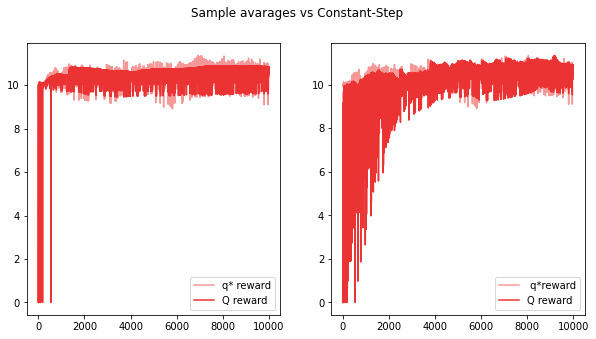

In [20]:
# X -> Passos/Episódios/Iterações
# y -> q*
# z -> Q

sample_averages_method_X = list(range(1, total_steps + 1))
sample_averages_method_y = list(map(lambda i: i[1], sample_averages_method.training_steps))
sample_averages_method_z = list(map(lambda i: i[2], sample_averages_method.training_steps))

constant_step_size_method_X = list(range(1, total_steps + 1))
constant_step_size_method_y = list(map(lambda i: i[1], constant_step_size_method.training_steps))
constant_step_size_method_z = list(map(lambda i: i[2], constant_step_size_method.training_steps))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Sample avarages vs Constant-Step')

ax1.plot(sample_averages_method_X, sample_averages_method_y, color=(0.92, 0.2, 0.2, 0.5), label='q* reward')
ax1.plot(constant_step_size_method_X, sample_averages_method_z, color=(0.92, 0.2, 0.2, 1), label='Q reward')
ax1.legend(loc="lower right")

ax2.plot(constant_step_size_method_X, constant_step_size_method_y, color=(0.92, 0.2, 0.2, 0.5), label=' q*reward')
ax2.plot(constant_step_size_method_X, constant_step_size_method_z, color=(0.92, 0.2, 0.2, 1), label='Q reward')
ax2.legend(loc="lower right")

Como mostra o gráfico comparativo, o método das médias tem problemas para acompanhar o valor real da recompensa em ambientes não-estacionários. Quanto maior a quantidade de iterações, mais o learning-rate tende a zero, ou seja, menos ajustes da recompensa esperada serão feitas para a ação específica.